In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt

from Util import *
import torch
from scipy import io
import sys


In [8]:

# Function to load the raw files
def load_data(folder, datalen):
    array_init=False
    
    ## Loop through data files in each folder
    for file in os.listdir(folder):
        if '.npy' in file:
            
            # Load the data
            data=np.load(os.path.join(folder,file),allow_pickle=True)
            
            #Seperate states and input fields
            states = data[:datalen,1:]
            input_ = data[:datalen,0].reshape(-1,1)
            
            # Initialise the array for all states
            if array_init==False:
                data_all = states
                input_all = input_



                array_init = True
            else:
                if len(data)>(datalen-1):
                    data_all=np.concatenate([data_all[:datalen],data[:datalen]],axis=1)
                    input_all=np.concatenate([input_all[:datalen],input_[:datalen]],axis=1)
                else:
                    print('File has less data than required - ', file)
    return data_all, input_all
# Load the Mackey Glass series from the manuscript
def Mackey_Manuscript(T_data):
    MG_paper = np.load('mackey_glass_t17.npy')
    MG_actual=[]
    for i in range(T_data):
        MG_actual.append(MG_paper[2*i])
    return MG_actual
# Define arbitrary Mackey Glass series      
def Mackey_Def(T_data,b=0.2,a=.1,tau=17,delta=10):
    
    N_pred=20
    burn_in=20

    T_gen=2*(T_data+burn_in+N_pred)

    s=torch.zeros([T_gen])

    s[0:tau]=1.1*torch.rand([tau])+0.2

    for t in range(tau,T_gen):

        s[t]=s[t-1]+b*s[t-tau]/(1+s[t-tau]**delta)-a*s[t-1]
    
    S=s[np.arange(0,np.floor(T_gen/2))*2]
    
    Signal=S[burn_in:-N_pred]
    
    Y=torch.zeros([Signal.size()[0],N_pred])

    for n in range(0,N_pred):

        Y[:,n]=S[burn_in+n:-N_pred+n]
        
    return Signal, Y

# Define the sine tasks
def Sine_Tasks(T_data,period = 30):
    
    x = np.arange(0,T_data)
    
    all_targets = []
    target_names = []
    
    ## Get sine variations
    sinx = np.sin(x*2*3.1415/(period))
    all_targets.append(sinx)
    target_names.append('sinx')
    sinp5x = np.sin(x*2*3.1415/(2*period))
    all_targets.append(sinp5x)
    target_names.append('sinp5x')
    sin2x = np.sin(x*2*3.1415/(0.5*period))
    all_targets.append(sin2x)
    target_names.append('sin2x')
    sin3x = np.sin(x*2*3.1415/((1/3)*period))
    all_targets.append(sin3x)
    target_names.append('sin3x')
    sin_squared = sinx**2
    all_targets.append(sin_squared)
    target_names.append('sin_squared')
    sin_cubed = sinx**3
    all_targets.append(sin_cubed)
    target_names.append('sin_cubed')
    
    #Get cos variations
    cosx = np.cos(x*2*3.1415/(period))
    all_targets.append(cosx)
    target_names.append('cosx')
    cosp5x = np.cos(x*2*3.1415/(2*period))
    all_targets.append(cosp5x)
    target_names.append('cosp5x')
    cos2x = np.cos(x*2*3.1415/(0.5*period))
    all_targets.append(cos2x)
    target_names.append('cos2x')
    cos3x= np.cos(x*2*3.1415/((1/3)*period))
    all_targets.append(cos3x)
    target_names.append('cos3x')
    
    #Get Saw variations
    sawx = signal.sawtooth(x*2*3.1415/(period))
    all_targets.append(sawx)
    target_names.append('sawx')
    saw2x = signal.sawtooth(x*2*3.1415/(0.5*period))
    all_targets.append(saw2x)
    target_names.append('saw2x')
    
    ## Scale all the above functions
    for i in range(len(all_targets)):
        all_targets[i] = (all_targets[i]-np.min(all_targets[i]))/(np.max(all_targets[i])-np.min(all_targets[i]))
    
    ## Append the tasks and names to a final list
    final_targets = []
    final_names = []
    for i in range(len(all_targets)):
        final_targets.append(all_targets[i])
        final_names.append(target_names[i])
    
    ## Add all of the base tasks previously defined
    for i in range(len(all_targets)):
        for j in range(len(all_targets)):
            if j>=i:
                new = (all_targets[i]+all_targets[j])
                new = (new-np.min(new))/(np.max(new)-np.min(new))
                final_targets.append(new)
                final_names.append(target_names[i]+'+'+target_names[j])

    ## Multiply all of the base tasks previously defined
    for i in range(len(all_targets)):
        for j in range(len(all_targets)):
            if j>=i:
                new = (all_targets[i]*all_targets[j])
                new = (new-np.min(new))/(np.max(new)-np.min(new))
                final_targets.append(new)
                final_names.append(target_names[i]+'*'+target_names[j])

    return final_targets, final_names

# Define the NARMA transforms
def NARMA(Y,n_back,T_data):
                
                
    

    signal=np.copy(Y);
    Y=np.zeros([T_data,n_back])    

    start=15

    for n in range(n_back):

        Y[:,n]=Narma(signal[:T_data],n,start)
    return Y
        
def Narma(s, step, start):

    
    T=np.shape(s)[0]
    y=torch.zeros([T])
    
    alpha=0.3
    beta=0.01
    gamma=2
    delta=0.1
    
    for t in range(step,T):
        
        y[t]=alpha*y[t-1]+beta*y[t-1]*torch.sum(y[t-step:t])+gamma*s[t-step]*s[t-1]+delta
        
            
    return y



In [2]:
## Function to analyse the predictions from the feature selection algorithm

## Function to 
def full_analysis(datafolder,targetname):
    
    fname = targetname+'_all'
    
    savdir = os.path.join(datafolder,'Feature_Selection')
    
    if os.path.isdir(savdir) is False:
        os.mkdir(savdir)

    ## Load the MSEs and features from the correlation step
    MSE_Te1 = io.loadmat(os.path.join(savdir,'Corr_MSETe'+fname+'.mat'))['array']
    Feats=[]
    for i in range(1):
        
        Feats1=io.loadmat(os.path.join(savdir,str(i)+'Corr_Feats2'+fname+'.mat'))['array']
        Feats.append(Feats1)
    

    ## Calculate the mean and standard deviations from the correlation step
    means_Corr = np.mean(np.mean(np.array(MSE_Te1),axis=0),0)
    stds_Corr = np.std(np.mean(np.array(MSE_Te1),axis=1),0)
    

    ## Load the MSE and features from the evolutionary step
    MSE_trials = io.loadmat(os.path.join(savdir,'Evol_MSE_trials'+fname+'.mat'))['array']
    RM = []
    for i in range(5):
        RM.append(io.loadmat(os.path.join(savdir,'Evol_RM'+fname+str(i)+'.mat'))['array'])
    
    # Calculate the mean and standard deviations from the evolutionary step
    means_evol = np.mean(np.mean(np.array(MSE_trials),axis=0),0)
    stds_evol = np.std(np.mean(np.array(MSE_trials),axis=1),0)
    ## Returns the means, standard deviations and features from correlation and evolutionary steps
    return means_Corr, stds_Corr, means_evol, stds_evol, Feats, RM
    

In [16]:

netfold = r'Data\Mackey_Glass\PNN\All' # Select the datafolder to analyse
data, inputs = load_data(netfold,250)

means_Corr, stds_Corr, means_evol, stds_evol, Feats_all, RM_all = full_analysis(netfold,'MG_predict')

# Sort the feature data to give the total number of features used.
all_lens_evol=np.zeros((1,5))
for i in range(5):
    RM = RM_all[i][0]
    num_features = data.shape[1]-len(RM)
    all_lens_evol[0][i]=num_features
all_lens_corr=np.zeros((1,5))
for i in range(5):
    num_features = len(np.where(Feats_all[0][i]==0)[0])
    all_lens_corr[0][i] = num_features
    
results = np.array([means_Corr,stds_Corr,means_evol,stds_evol])
print(all_lens_corr,all_lens_evol)


File has less data than required -  19.I-MS_300_R-PW_.npy
File has less data than required -  37.I-MS_300_R-WM_.npy
File has less data than required -  6.I-MS_320-250_R-MS_.npy
[[13590. 13594. 13557. 13590. 13583.]] [[13567. 13573. 13571. 13570. 13569.]]


Text(0, 0.5, 'MSE')

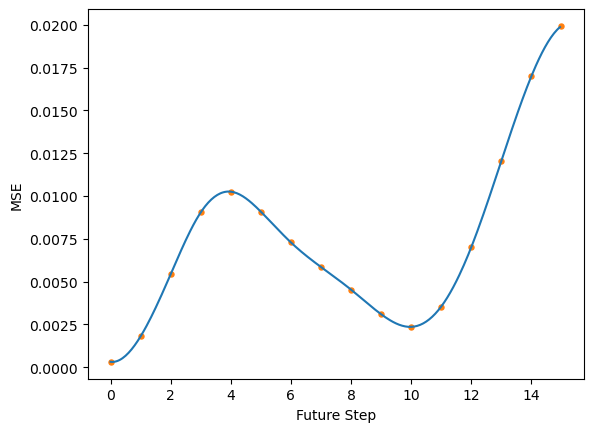

In [20]:
import scipy as sp
fig,ax = plt.subplots()

x = np.arange(0,len(results[2]))

xx=np.arange(0,max(x),0.05)#:max(x)
yy_up=sp.interpolate.interp1d(x, results[2]-2*results[3], kind='cubic')(xx)
yy_down=sp.interpolate.interp1d(x, results[2]+2*results[3], kind='cubic')(xx)
yy = sp.interpolate.interp1d(x, results[2], kind='cubic')(xx)
#print(results_Gen[0])
ax.fill_between(xx,yy_down,yy_up,alpha=0.5)
ax.scatter(x[:len(results[2])],results[2],s=13)

ax.plot(xx[:len(yy)],yy)
ax.set_xlabel('Future Step')
ax.set_ylabel('MSE')

In [4]:
## Loop through all datafolders and save the response to a dictionary

folder = r'Data\Mackey_Glass'
all_ = {}
network_list = []
task = 'NARMA_pred'
for task in ['NARMA_pred','MG_predict','NARMA']:
    for type_ in os.listdir(folder):
        typefolder = os.path.join(folder,type_)
        if os.path.isdir(typefolder):
            for network in os.listdir(typefolder):
                netfold = os.path.join(typefolder,network)
                if os.path.isdir(netfold) and 'Clean_data' not in netfold and 'Individual' not in netfold:
                    print(netfold)
                    try:
                        data, inputs = load_data(netfold,250)
                        network_list.append(network)
                        ## Returns the means and stds of the correlation and evolution steps. Feats_all is the features from the correlation step. RM_all is the features removed from the evolution step.
                       
                        means_Corr, stds_Corr, means_evol, stds_evol, Feats_all, RM_all = full_analysis(netfold,np.zeros(250),task,method,False)
                        #print(means_evol)
                        
                        all_lens_evol=np.zeros((1,5))
                        for i in range(5):
                            RM = RM_all[i][0]
                            num_features = data.shape[1]-len(RM)
                            all_lens_evol[0][i]=num_features
                        all_lens_corr=np.zeros((1,5))
                        for i in range(5):
                            num_features = len(np.where(Feats_all[0][i]==0)[0])
                            all_lens_corr[0][i] = num_features
                            

                        
                        result_Gen = np.array([means_Corr,stds_Corr,means_evol,stds_evol])
                        all_[network] = [[result_Gen,all_lens_corr,all_lens_evol]]
                    except:
                        print('fail',network)
                        pass
    import pickle
    # save dictionary to person_data.pkl file
    with open(str(task)+'.pkl', 'wb') as fp:
        pickle.dump(all_, fp)
        print('dictionary saved successfully to file')

MG_Feature_Selection\Responses\Parallel\P1
MG_Feature_Selection\Responses\Parallel\P2
MG_Feature_Selection\Responses\Parallel\P3
MG_Feature_Selection\Responses\Parallel\Pall
MG_Feature_Selection\Responses\PNN\All
File has less data than required -  19.I-MS_300_R-PW_.npy
File has less data than required -  37.I-MS_300_R-WM_.npy
File has less data than required -  6.I-MS_320-250_R-MS_.npy
MG_Feature_Selection\Responses\PNN\JustMS
File has less data than required -  6.I-MS_320-250_R-MS_.npy
MG_Feature_Selection\Responses\PNN\JustPW
File has less data than required -  19.I-MS_300_R-PW_.npy
MG_Feature_Selection\Responses\PNN\JustWM
File has less data than required -  37.I-MS_300_R-WM_.npy
MG_Feature_Selection\Responses\Series\S1
MG_Feature_Selection\Responses\Series\S10
MG_Feature_Selection\Responses\Series\S11
MG_Feature_Selection\Responses\Series\S12
MG_Feature_Selection\Responses\Series\S13
MG_Feature_Selection\Responses\Series\S14
MG_Feature_Selection\Responses\Series\S15
MG_Feature_Sel

In [93]:
folder = r'Data\SINE'
all_ = {}
network_list = []
task = 'SINE'
for type_ in os.listdir(folder):
    typefolder = os.path.join(folder,type_)
    if os.path.isdir(typefolder):
        for network in os.listdir(typefolder):
            netfold = os.path.join(typefolder,network)
            if os.path.isdir(netfold) and 'Clean_data' not in netfold:
                
                try:
                    data, inputs = load_data(netfold,250)
                    network_list.append(network)
                    ## Returns the means and stds of the correlation and evolution steps. Feats_all is the features from the correlation step. RM_all is the features removed from the evolution step.
                    
                    
                    means_Corr, stds_Corr, means_evol, stds_evol, Feats_all, RM_all = full_analysis(netfold,task)
                    
                    
                    all_lens_evol=np.zeros((1,5))
                    for i in range(5):
                        RM = RM_all[i][0]
                        num_features = data.shape[1]-len(RM)
                        all_lens_evol[0][i]=num_features
                    all_lens_corr=np.zeros((1,5))
                    for i in range(5):
                        
                        num_features = len(np.where(Feats_all[0][i]==0)[0])
                        all_lens_corr[0][i] = num_features
                        

                    
                    result_Gen = np.array([means_Corr,stds_Corr,means_evol,stds_evol])
                    all_[network] = [[result_Gen,all_lens_corr,all_lens_evol]]
                except:
                    print('fail',network)
                    pass
import pickle
# save dictionary to person_data.pkl file
with open(r'SINE.pkl', 'wb') as fp:
    pickle.dump(all_, fp)
    print('dictionary saved successfully to file')

[]


C:\Users\kjs18\AppData\Local\Temp\ipykernel_13992\4219231823.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_Gen = np.array([means_Corr,stds_Corr,means_evol,stds_evol,all_lens_corr,all_lens_evol])


['nah', 'nah', 'nah', 'nah', 'nah', 'nah', 'nah', [array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])], [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])], [array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.]])], [array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])], [array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., .